In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import os

In [2]:
base_pth = "./CroppedYale"
subjects_folders = os.listdir(base_pth)
print(len(subjects_folders))

# list of lists
subjects_imgs_names = []
# 38 subject 65 images each (some corrupted)
for subject in subjects_folders:
    allFiles = os.listdir(f"./{base_pth}/{subject}") 
    pgms = [ fname for fname in allFiles if fname.endswith('.pgm')]
    subjects_imgs_names.append(pgms)


38


In [3]:
# list of lists of subject imgs


import shutil
unique_subject = []
for folder in subjects_imgs_names:
    unique_subject.append(folder[1])
    unique_subject.append(folder[2])
    unique_subject.append(folder[10])
    unique_subject.append(folder[15])
    unique_subject.append(folder[20])
    unique_subject.append(folder[25])
    unique_subject.append(folder[50])

unique_imgs_pth = []
for name in unique_subject:
    folder_name = name.split("_")[0]
    unique_imgs_pth.append(f"{folder_name}/{name}")
    
# unique_imgs_pth[5] 'yaleB06/yaleB06_P00A+000E+90.pgm'

print(len(unique_imgs_pth))

for i in range(len(unique_imgs_pth)):
    shutil.copy(f"{base_pth}/{unique_imgs_pth[i]}", f"unique_faces/")
    
        

266


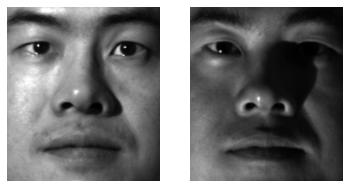

In [4]:
subjects_imgs = os.listdir("./unique_faces")
len(subjects_imgs)

# 228 img 6 for each subject 38x6
recognition_pgms = []
for img in subjects_imgs:
        pgm = plt.imread(f"./unique_faces/{img}")
        recognition_pgms.append(pgm)


fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(recognition_pgms[10], cmap="gray")
img_avg.set_cmap('gray')
plt.axis('off')

ax2 = fig1.add_subplot(122)
img_u1 = ax2.imshow(recognition_pgms[11], cmap="gray")
img_u1.set_cmap('gray')
plt.axis('off')
plt.show()


In [5]:
m = 192
n = 168 
# testing_pgms_arr
recognition_pgms_arr = np.array(recognition_pgms) #, dtype=object
# recognition_pgms_arr = np.array(testing_pgms)

recognition_pgms_vectors = []
for img in recognition_pgms_arr:
    img_flat = img.flatten()
    recognition_pgms_vectors.append(img_flat)

recognition_pgms_vectors = np.array(recognition_pgms_vectors) #, dtype=object

(192, 168)


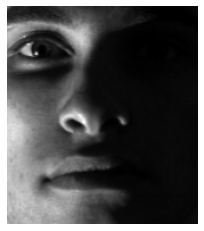

In [6]:
# testing_pgms_arr# X = training_pgms_vectors >> reshape and vector to (192,168)
rand_int = np.random.randint(0,len(recognition_pgms_arr))
img_reshaped = recognition_pgms_vectors[rand_int].reshape(m,n)
print(img_reshaped.shape)
plt.figure(figsize=(4., 4.))
plt.axis('off')   
plt.imshow(img_reshaped, plt.cm.gray)
plt.show()    


vector_list shape (266, 32256)
vector_list.T shape (32256, 266)
X_recognition shape (32256, 266)


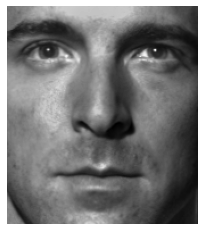

In [7]:
#  load avg_face
avg_face = np.loadtxt('avg_face.txt', dtype=int) #(32256,)

# Turn to numppy array of lists
vectors_list = []
for vector in recognition_pgms_vectors:
    vectors_list.append(vector.tolist())

# n_imgs x (nxm)
print("vector_list shape",np.array(vectors_list).shape)  

# (nxm) x k
vectors_list =  np.array(vectors_list).T 
print("vector_list.T shape",np.array(vectors_list).shape)   

# copy avg face n times
avg_face_list  = []
for i in range(len(vectors_list[1])):
    avg_face_list.append(avg_face.tolist())

avg_face_list =  np.array(avg_face_list).T

    
X_recognition = vectors_list - avg_face_list
print("X_recognition shape",X_recognition.shape)

# X = training_pgms_vectors >> reshape and vector to (192,168)
rand_int = np.random.randint(0,len(recognition_pgms_arr))
img_reshaped = X_recognition.T[rand_int].reshape(m,n)
plt.figure(figsize=(4., 4.))
plt.axis('off')   
plt.imshow(img_reshaped, plt.cm.gray)
plt.show()    


In [8]:
U = np.loadtxt('U.txt')

In [69]:
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import pandas as pd

# U = np.loadtxt('U.txt', dtype=int)
def fit_svc_model(x_train, x_test, y_train, y_test):
    # svc = SVC(kernel='rbf', class_weight='balanced')
    svc = SVC(kernel='linear')
    model = make_pipeline(svc)
    
    param_grid = {'svc__C': [1, 5, 10, 50],
                  'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
    grid = GridSearchCV(model, param_grid)
    
    grid.fit(x_train, y_train)
    # print(grid.best_params_)
    
    model = grid.best_estimator_
    yfit = model.predict(x_test)
    return yfit

#  note:: from 15 to 39 labeled 14 to 38
def get_roc_data(start=5, end=7, data_shape=tuple):
    PCAmodes = [i for i in range(start,end)]

    counter = 0
    person_num = 1
    df_prev = pd.DataFrame()
    for i in range(data_shape[0]):
        PCA_P = U[ : , PCAmodes-np.ones_like(PCAmodes)].T @ X_recognition[ : ,    counter : counter+data_shape[1]]    
        counter += data_shape[1]
        df = pd.DataFrame(PCA_P.T)
        df['Person'] = person_num
        person_num +=1 
        df = pd.concat([df_prev,df], axis=0)
        df_prev = df 
        if person_num == data_shape[0]+1:
            break

    df_y = df.pop('Person')
    df_x = df    
    x_train,x_test,y_train,y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=40)
    yfit  = fit_svc_model(x_train,x_test,y_train,y_test)
    return y_test, yfit

In [80]:
y_test, yfit = get_roc_data(5,50,data_shape=(len(unique_imgs_pth),7))
from sklearn.metrics import classification_report
print(classification_report(y_test, yfit))

c:\Users\Mohamed Abdelaziz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         3
           7       0.40      1.00      0.57         2
           8       0.00      0.00      0.00         2
           9       0.67      0.67      0.67         3
          10       1.00      0.50      0.67         2
          13       1.00      0.67      0.80         3
          15       1.00      0.33      0.50         3
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.75      1.00      0.86         3
          19       0.67      0.67      0.67         3
          20       1.00      1.00      1.00         1
          21       1.00    

c:\Users\Mohamed Abdelaziz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mohamed Abdelaziz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mohamed Abdelaziz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

In [30]:
y_test, yfit = get_roc_data(5,300,data_shape=(len(unique_imgs_pth),7))
from sklearn.metrics import classification_report
print(classification_report(y_test, yfit))

c:\Users\Mohamed Abdelaziz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'svc__C': 1, 'svc__gamma': 0.0001}
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       0.40      1.00      0.57         2
           8       0.00      0.00      0.00         2
           9       0.67      0.67      0.67         3
          10       0.20      0.50      0.29         2
          13       1.00      0.67      0.80         3
          15       1.00      0.33      0.50         3
          16       0.00      0.00      0.00         1
          17       1.00      1.00      1.00         1
          18       1.00      1.00      1.00         3
          19       1.00      0.67      0.80         3
          20       1.00      1.00      1.00  

c:\Users\Mohamed Abdelaziz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mohamed Abdelaziz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mohamed Abdelaziz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

In [91]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

def plot_roc_multiclass(y_test, y_pred, start,end):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    iter_list = [i for i in range(start,end+1)]
    for i in iter_list:
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    for i in iter_list:
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    


def get_df_data(start=5, end=7, data_shape=tuple):
    PCAmodes = [i for i in range(start,end)]

    counter = 0
    person_num = 1
    df_prev = pd.DataFrame()
    for i in range(data_shape[0]):
        PCA_P = U[ : , PCAmodes-np.ones_like(PCAmodes)].T @ X_recognition[ : ,    counter : counter+data_shape[1]]    
        counter += data_shape[1]
        df = pd.DataFrame(PCA_P.T)
        df['Person'] = person_num
        person_num +=1 
        df = pd.concat([df_prev,df], axis=0)
        df_prev = df 
        if person_num == data_shape[0]+1:
            break
        
    df_y = df.pop('Person')
    df_x = df
    return df_x, df_y

X, y = get_df_data(5,300, data_shape=(len(unique_imgs_pth),7))

persons_classes = [i for i in range(1,39)]
# Binarize the output
y = label_binarize(y, classes=persons_classes)
n_classes = y.shape[1]

# # shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=40))
y_pred = classifier.fit(X_train, y_train).decision_function(X_test)






Automatically created module for IPython interactive environment


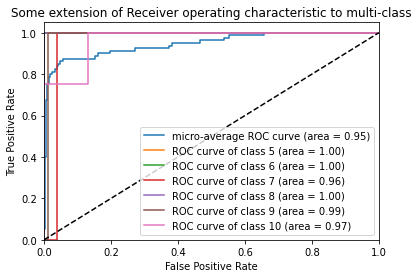

In [92]:
plot_roc_multiclass(y_test, y_pred, start=5, end=10)

c:\Users\Mohamed Abdelaziz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
c:\Users\Mohamed Abdelaziz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


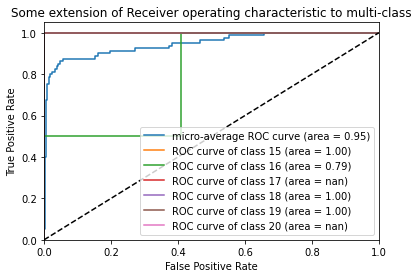

In [93]:
plot_roc_multiclass(y_test, y_pred, start=15, end=20)

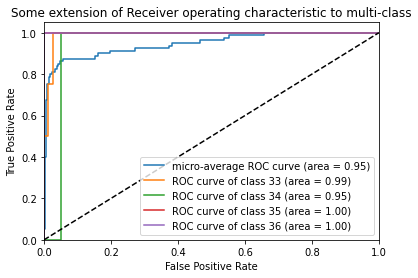

In [94]:
plot_roc_multiclass(y_test, y_pred, start=33, end=36)